In [2]:
import numpy as np
import pandas as pd
import findspark 


# from datetime import datetime
# from collections import Counter
# from subprocess import check_output

# import matplotlib.pyplot as plt
# import seaborn as sns

# import pyspark
# from pyspark import SparkContext, SparkConf
# from pyspark.sql import SQLContext
# from pyspark.sql import SparkSession
# from pyspark.sql.functions import unix_timestamp, from_unixtime

In [130]:
pd_train=pd.read_csv('train.csv')
pd_train_v2=pd.read_csv('train_v2.csv')
pd_sub=pd.read_csv('sample_submission_zero.csv')
pd_sub_v2=pd.read_csv('sample_submission_v2.csv')
pd_trans=pd.read_csv('transactions.csv')
pd_trans_v2=pd.read_csv('transactions_v2.csv')
pd_users_v2=pd.read_csv('user_logs_v2.csv')
pd_member=pd.read_csv('members_v3.csv')

In [3]:
pd_train_all=pd.concat([pd_train,pd_train_v2])
pd_train_all['msno'].describe()

NameError: name 'pd_train' is not defined

In [157]:
pd_train_all=pd_train_all.drop_duplicates()
pd_train_all.shape

(1128180, 2)

In [168]:
pd_sub_all=pd.concat([pd_sub,pd_sub_v2])
pd_sub_all['msno'].describe()

count                                          1878431
unique                                         1076941
top       a2h/k2Wgq12p/jTBqcZEkjYMWLwJ30GWFe7saJF+bF8=
freq                                                 2
Name: msno, dtype: object

In [186]:
user_id=pd.concat([pd_train_all,pd_sub_all])
pd_distinct_id=user_id['msno'].drop_duplicates()
pd_distinct_id.describe()

count                                          1143472
unique                                         1143472
top       MuJj2DtF+wZWVPpvvaV3I9h/+axyHF8LiR5etZ14ojw=
freq                                                 1
Name: msno, dtype: object

In [185]:
pd_member_clean=pd_member[pd_member['msno'].isin(pd_distinct_id)]
print(pd_member_clean.shape)
pd_member_clean

(1018235, 6)


,msno,city,bd,gender,registered_via,registration_init_time
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,20110914
4,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,female,9,20110915
5,yLkV2gbZ4GLFwqTOXLVHz0VGrMYcgBGgKZ3kj9RiYu8=,4,30,male,9,20110916
7,WH5Jq4mgtfUFXh2yz+HrcTXKS4Oess4k4W3qKolAeb0=,5,34,male,9,20110916
9,I0yFvqMoNkM8ZNHb617e1RBzIS/YRKemHO7Wj13EtA0=,13,63,male,9,20110918
...,...,...,...,...,...,...
6769443,dz8iQV2eZCBZo1DjKL7OifsiyzGf3xyMaCFDOJHVeyc=,1,0,NaN,7,20151020
6769465,OL6joplCKThE1pZD+AQDnj3kZiC45qzpndlDIRSyPQI=,1,0,NaN,7,20151020
6769466,O11rAa17ANM6DGMMVb9L2vwCQFv/S6SR3SDB1nGuOAc=,1,0,NaN,7,20151020
6769467,tyoRqQ72Y2oCcqvdaIxG8T0Hs9DZvuuM8IeTwhxtdBQ=,6,26,female,7,20151020


In [211]:
pd_member_churn=pd.merge(pd_train_all,pd_member_clean,how='left',on='msno')
pd_member_churn=pd_member_churn.drop_duplicates()
print(pd_member_churn.shape)
pd_member_churn.info()

(1128180, 7)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128180 entries, 0 to 1963874
Data columns (total 7 columns):
msno                      1128180 non-null object
is_churn                  1128180 non-null int64
city                      1003977 non-null float64
bd                        1003977 non-null float64
gender                    467072 non-null object
registered_via            1003977 non-null float64
registration_init_time    1003977 non-null float64
dtypes: float64(4), int64(1), object(2)
memory usage: 68.9+ MB


In [212]:
pd_member_churn['city'] = pd_member_churn.city.apply(lambda x: int(x) if pd.notnull(x) else "NAN")
pd_member_churn['registered_via'] = pd_member_churn.registered_via.apply(lambda x: int(x) if pd.notnull(x) else "NAN")
pd_member_churn['gender']=pd_member_churn['gender'].fillna("NAN")
pd_member_churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128180 entries, 0 to 1963874
Data columns (total 7 columns):
msno                      1128180 non-null object
is_churn                  1128180 non-null int64
city                      1128180 non-null object
bd                        1003977 non-null float64
gender                    1128180 non-null object
registered_via            1128180 non-null object
registration_init_time    1003977 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 68.9+ MB


In [213]:
pd_member_churn['registration_init_time'] = pd_member_churn.registration_init_time.apply(lambda x: datetime.strptime(str(int(x)), "%Y%m%d").date() if pd.notnull(x) else "NAN" )
pd_member_churn.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,18,36.0,female,9,2005-04-06
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,10,38.0,male,9,2005-04-07
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1,11,27.0,female,9,2005-10-16
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1,13,23.0,female,9,2005-11-02
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1,3,27.0,male,9,2005-12-28


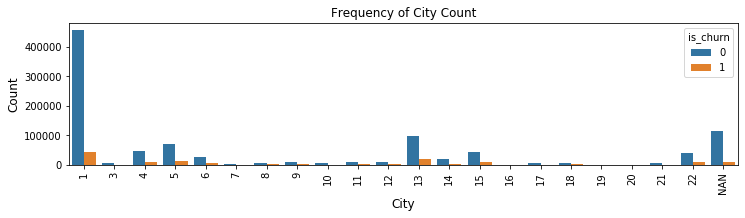

City Count [(1, 503285), ('NAN', 124203), (13, 115648), (5, 84955), (4, 56913), (15, 51714), (22, 50222), (6, 31186), (14, 23670), (12, 13871), (9, 11278), (11, 10823), (18, 9291), (8, 9211), (10, 7812), (17, 6413), (21, 6411), (3, 6085), (7, 3132), (16, 1104), (20, 793), (19, 160)]


In [238]:
plt.figure(figsize=(12,12))
plt.subplot(411)
city_order = pd_member_churn['city'].unique()
city_order=sorted(city_order, key=lambda x: float(x))
sns.countplot(x="city", hue='is_churn',data=pd_member_churn , order = city_order)
plt.ylabel('Count', fontsize=12)
plt.xlabel('City', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of City Count", fontsize=12)
plt.show()

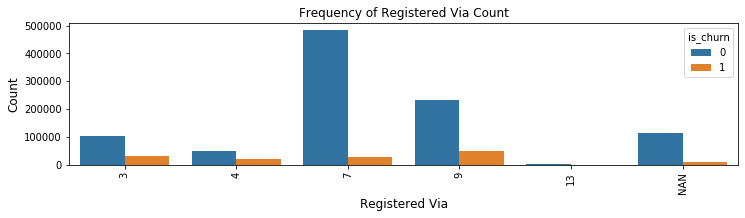

In [239]:
#Registered Via Count
plt.figure(figsize=(12,12))
plt.subplot(412)
R_V_order = pd_member_churn['registered_via'].unique()
R_V_order = sorted(R_V_order, key=lambda x: str(x))
R_V_order = sorted(R_V_order, key=lambda x: float(x))
#above repetion of commands are very silly, but this was the only way I was able to diplay what I wanted
sns.countplot(x="registered_via", hue='is_churn',data=pd_member_churn,order = R_V_order)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Registered Via', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Registered Via Count", fontsize=12)
plt.show()

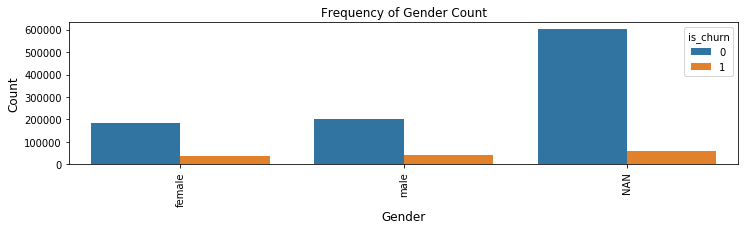

In [240]:
plt.figure(figsize=(12,12))
plt.subplot(413)
sns.countplot(x="gender", hue='is_churn',data=pd_member_churn)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Gender Count", fontsize=12)
plt.show()

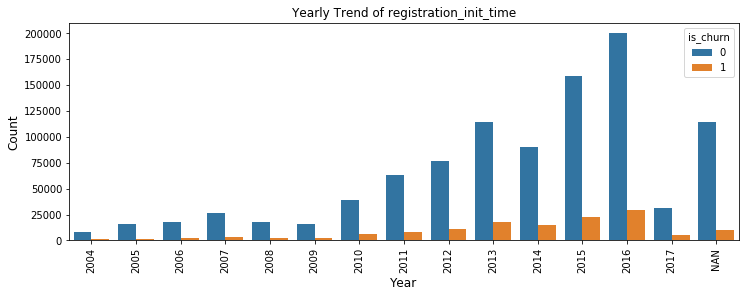

In [278]:
pd_member_churn['registration_init_time_year'] = pd.DatetimeIndex(pd_member_churn['registration_init_time']).year
pd_member_churn['registration_init_time_year'] = pd_member_churn.registration_init_time_year.apply(lambda x: int(x) if pd.notnull(x) else "NAN" )
year_count_0=pd.DataFrame({'year':pd_member_churn[pd_member_churn['is_churn']==0]['registration_init_time_year'].value_counts().index,
                           'year_count':pd_member_churn[pd_member_churn['is_churn']==0]['registration_init_time_year'].value_counts(),
                           'is_churn': np.zeros(len(pd_member_churn[pd_member_churn['is_churn']==0]['registration_init_time_year'].value_counts()))})
year_count_1=pd.DataFrame({'year':pd_member_churn[pd_member_churn['is_churn']==1]['registration_init_time_year'].value_counts().index,
                           'year_count':pd_member_churn[pd_member_churn['is_churn']==1]['registration_init_time_year'].value_counts(),
                           'is_churn': np.ones(len(pd_member_churn[pd_member_churn['is_churn']==1]['registration_init_time_year'].value_counts()))})
year_count=pd.concat([year_count_0,year_count_1])

plt.figure(figsize=(12,4))
year_order = pd_member_churn['registration_init_time_year'].unique()
year_order=sorted(year_order, key=lambda x: str(x))
year_order = sorted(year_order, key=lambda x: float(x))
sns.countplot(x='registration_init_time_year', hue='is_churn',data=pd_member_churn,order=year_order)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Yearly Trend of registration_init_time", fontsize=12)
plt.show()

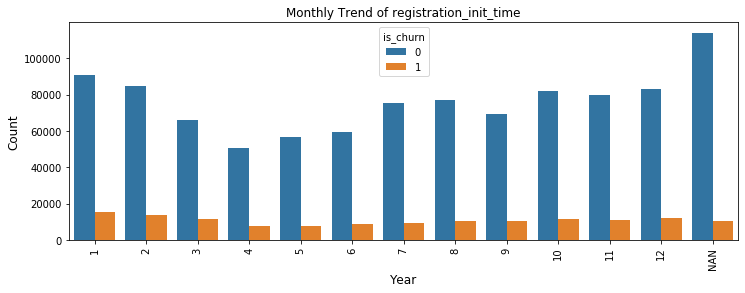

In [280]:
pd_member_churn['registration_init_time_month'] = pd_member_churn.registration_init_time_month.apply(lambda x: int(x) if pd.notnull(x) else "NAN" )

plt.figure(figsize=(12,4))
month_order = pd_member_churn['registration_init_time_month'].unique()
month_order=sorted(month_order, key=lambda x: str(x))
month_order = sorted(month_order, key=lambda x: float(x))
sns.countplot(x='registration_init_time_month', hue='is_churn',data=pd_member_churn,order=month_order)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Monthly Trend of registration_init_time", fontsize=12)
plt.show()

In [281]:
pd_member_churn['registration_init_time_weekday'] = pd.DatetimeIndex(pd_member_churn['registration_init_time']).weekday_name
pd_member_churn['registration_init_time_weekday'] = pd_member_churn.registration_init_time_weekday.apply(lambda x: str(x) if pd.notnull(x) else "NAN" )

plt.figure(figsize=(12,4))
weekday_order = pd_member_churn['registration_init_time_weekday'].unique()
weekday_order=sorted(weekday_order, key=lambda x: str(x))
weekday_order = sorted(weekday_order, key=lambda x: float(x))
sns.countplot(x='registration_init_time_weekday', hue='is_churn',data=pd_member_churn,order=month_order)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Daily Trend of registration_init_time", fontsize=12)
plt.show()

ValueError: could not convert string to float: 'Friday'

<Figure size 864x288 with 0 Axes>

In [242]:

#registration_init_time day wise trend
training['registration_init_time_weekday'] = pd.DatetimeIndex(training['registration_init_time']).weekday_name
training['registration_init_time_weekday'] = training.registration_init_time_weekday.apply(lambda x: str(x) if pd.notnull(x) else "NAN" )
day_count=training['registration_init_time_weekday'].value_counts()
plt.figure(figsize=(12,12))
plt.subplot(313)
#day_order = training['registration_init_time_day'].unique()
day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday','NAN']
sns.barplot(day_count.index, day_count.values,order=day_order)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Day-wise Trend of registration_init_time", fontsize=12)
plt.show()
day_count_2 = Counter(training['registration_init_time_weekday']).most_common()
print("Day-wise Count " +str(day_count_2))

SyntaxError: positional argument follows keyword argument (<ipython-input-242-c7c854ff062d>, line 11)

In [188]:
pd_trans_all=pd.concat([pd_trans,pd_trans_v2])
print(pd_trans_all.shape)
pd_trans_all=pd_trans_all.drop_duplicates()
print(pd_trans_all.shape)
pd_trans_clean=pd_trans_all[pd_trans_all['msno'].isin(pd_distinct_id)]
print(pd_trans_clean.shape)
pd_trans_clean

(22978755, 9)
(22975416, 9)
(17858127, 9)


,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,20150930,20151101,0
1,AZtu6Wl0gPojrEQYB8Q3vBSmE2wnZ3hi1FbK1rQQ0A4=,41,30,149,149,1,20150930,20151031,0
4,yvj6zyBUaqdbUQSrKsrZ+xNDVM62knauSZJzakS9OW4=,39,30,149,149,1,20150930,20151121,0
5,KN7I82kjY0Tn76Ny95ncqBUVbO7b8AXrOPqZutKpxIM=,21,30,149,149,1,20150930,20151107,0
6,m5ptKif9BjdUghHXXomSezy5ohJiHm85PE13f/3kQaw=,39,30,149,149,1,20150930,20151128,0
...,...,...,...,...,...,...,...,...,...
1431003,zviO0RLvsXAzgz894wMm5b9Nxp8yxFAuqHY1Nq0lq3M=,36,30,180,180,1,20170316,20170415,0
1431004,zwF50wwaJI2TBKWhB42HRBJ6EQK0jgSo1Xmwb9Jq3SU=,32,180,536,536,0,20170215,20170817,0
1431005,zx/h5MzQQmsSat04wSfGpHp6N8aWLLwM1+7OV7ujmPY=,41,30,149,149,1,20170306,20170406,0
1431006,zxvgjIKjy18Fm+cIWUfYKr68z09+ILBxuMW0DnbeUZ8=,41,30,99,99,1,20170308,20170408,0


In [189]:
pd_trans_clean['msno'].describe()

count                                         17858127
unique                                         1143472
top       72gJqt1O31E/WoxAEYFn9LHNI6mAZFGera5Q6gvsFkA=
freq                                               244
Name: msno, dtype: object

In [2]:
sqlContext = SQLContext(sc)
#spark=SparkSession.builder.config("spark.default.parallelism", 4000).appName("taSpark").getOrCreate()
sc =SparkContext()

In [3]:
train = sqlContext.read.format('com.databricks.spark.csv').options(header='true', 
inferschema='true').load('train.csv')
train.show()

+--------------------+--------+
|                msno|is_churn|
+--------------------+--------+
|waLDQMmcOu2jLDaV1...|       1|
|QA7uiXy8vIbUSPOkC...|       1|
|fGwBva6hikQmTJzrb...|       1|
|mT5V8rEpa+8wuqi6x...|       1|
|XaPhtGLk/5UvvOYHc...|       1|
|GBy8qSz16X5iYWD+3...|       1|
|lYLh7TdkWpIoQs3i3...|       1|
|T0FF6lumjKcqEO0O+...|       1|
|Nb1ZGEmagQeba5E+n...|       1|
|MkuWz0Nq6/Oq5fKqR...|       1|
|I8dFN2EjFN1mt4Xel...|       1|
|0Ip2rzeoa44alqEw3...|       1|
|piVhWxrWDmiNQFY6x...|       1|
|wEUOkYvyz3xTOx2p9...|       1|
|xt4EjWRyXBMgEgKBJ...|       1|
|QS3ob4zLlWcWzBIlb...|       1|
|9iW/UpqRoviya9CQh...|       1|
|d7QVMhAzjj4yc1Ojj...|       1|
|uV7rJjHPrpNssDMmY...|       1|
|TZxhkfZ9NwxqnUrNs...|       1|
+--------------------+--------+
only showing top 20 rows



In [4]:
train.describe(traixixikuain.columns).show()

+-------+--------------------+-------------------+
|summary|                msno|           is_churn|
+-------+--------------------+-------------------+
|  count|              992931|             992931|
|   mean|                null|0.06392287077349786|
| stddev|                null|0.24461561198821244|
|    min|+++hVY1rZox/33Ytv...|                  0|
|    max|zzzN9thH22os1dRS0...|                  1|
+-------+--------------------+-------------------+



In [125]:
print((train.count(), len(train.columns)))
for i in train.columns:
    print(i,train.where(train[i].isNull()).count())
print(train.select(['msno']).distinct().count())

(992931, 2)
msno 0
is_churn 0
992931


In [9]:
train_v2 = sqlContext.read.format('com.databricks.spark.csv').options(header='true', 
inferschema='true').load('train_v2.csv')
train_v2.show()

+--------------------+--------+
|                msno|is_churn|
+--------------------+--------+
|ugx0CjOMzazClkFzU...|       1|
|f/NmvEzHfhINFEYZT...|       1|
|zLo9f73nGGT1p21lt...|       1|
|8iF/+8HY8lJKFrTc7...|       1|
|K6fja4+jmoZ5xG6By...|       1|
|ibIHVYBqxGwrSExE6...|       1|
|kVmM8X4iBPCOfK/m1...|       1|
|moRTKhKIDvb+C8ZHO...|       1|
|dW/tPZMDh2Oz/ksdu...|       1|
|otEcMhAX3mU4gumUS...|       1|
|t5rqTxCnG7s5VBgEf...|       1|
|dfLS2/Pom6O3iUpo+...|       1|
|a7AtvhlY8KnKZGpiV...|       1|
|F45GsXJIeLvzUJqz/...|       1|
|SJCoxreWp6Cu9WPit...|       1|
|Oo2RDQixJ0pRWqec4...|       1|
|f91n3lDipDjRtAVNg...|       1|
|/L2095JD4M/BNLTCb...|       1|
|1AzXWFlRO6EfMBzfB...|       1|
|WkF/FvlzpBLFoa+Hm...|       1|
+--------------------+--------+
only showing top 20 rows



In [31]:
train_v2.describe(train_v2.columns).show()

+-------+--------------------+-------------------+
|summary|                msno|           is_churn|
+-------+--------------------+-------------------+
|  count|              970960|             970960|
|   mean|                null|0.08994191315811156|
| stddev|                null| 0.2860986712938504|
|    min|+++hVY1rZox/33Ytv...|                  0|
|    max|zzzF1KsGfHH3qI6qi...|                  1|
+-------+--------------------+-------------------+



In [127]:
print((train_v2.count(), len(train_v2.columns)))
for i in train_v2.columns:
    print(i,train_v2.where(train_v2[i].isNull()).count())
print(train_v2.select(['msno']).distinct().count())

(970960, 2)
msno 0
is_churn 0
970960


In [10]:
sub = sqlContext.read.format('com.databricks.spark.csv').options(header='true', 
inferschema='true').load('sample_submission_zero.csv')
sub.show()

+--------------------+--------+
|                msno|is_churn|
+--------------------+--------+
|ugx0CjOMzazClkFzU...|       0|
|f/NmvEzHfhINFEYZT...|       0|
|zLo9f73nGGT1p21lt...|       0|
|8iF/+8HY8lJKFrTc7...|       0|
|K6fja4+jmoZ5xG6By...|       0|
|ibIHVYBqxGwrSExE6...|       0|
|kVmM8X4iBPCOfK/m1...|       0|
|moRTKhKIDvb+C8ZHO...|       0|
|dW/tPZMDh2Oz/ksdu...|       0|
|otEcMhAX3mU4gumUS...|       0|
|t5rqTxCnG7s5VBgEf...|       0|
|dfLS2/Pom6O3iUpo+...|       0|
|a7AtvhlY8KnKZGpiV...|       0|
|F45GsXJIeLvzUJqz/...|       0|
|SJCoxreWp6Cu9WPit...|       0|
|Oo2RDQixJ0pRWqec4...|       0|
|f91n3lDipDjRtAVNg...|       0|
|/L2095JD4M/BNLTCb...|       0|
|1AzXWFlRO6EfMBzfB...|       0|
|WkF/FvlzpBLFoa+Hm...|       0|
+--------------------+--------+
only showing top 20 rows



In [33]:
sub.describe(sub.columns).show()

+-------+--------------------+--------+
|summary|                msno|is_churn|
+-------+--------------------+--------+
|  count|              970960|  970960|
|   mean|                null|     0.0|
| stddev|                null|     0.0|
|    min|+++hVY1rZox/33Ytv...|       0|
|    max|zzzF1KsGfHH3qI6qi...|       0|
+-------+--------------------+--------+



In [34]:
print((sub.count(), len(sub.columns)))
for i in sub.columns:
    print(i,sub.where(sub[i].isNull()).count())

(970960, 2)
msno 0
is_churn 0


In [11]:
sub_v2 = sqlContext.read.format('com.databricks.spark.csv').options(header='true', 
inferschema='true').load('sample_submission_v2.csv')
sub_v2.show()

+--------------------+--------+
|                msno|is_churn|
+--------------------+--------+
|4n+fXlyJvfQnTeKXT...|       0|
|aNmbC1GvFUxQyQUid...|       0|
|rFC9eSG/tMuzpre6c...|       0|
|WZ59dLyrQcE7ft06M...|       0|
|aky/Iv8hMp1/V/yQH...|       0|
|nu1jZ/flvSaXRg0U9...|       0|
|biDTtgK83fEWXJDax...|       0|
|k/8uwi/iM9LZmRAIW...|       0|
|18rQ/746SjA6nBx32...|       0|
|2V13OCoWx6vqKr/Zz...|       0|
|1l/ZwduFxS/q/hZey...|       0|
|azfnO16ZeQsbJF6Lc...|       0|
|RPOzeEr8mSbhj6wrF...|       0|
|NAzfjSM2EOyFhV4rI...|       0|
|1DCd06ON0rWFHI1bN...|       0|
|D9QAV8ZNF8qU96dTB...|       0|
|5HKzLDUVVbIxWMH9a...|       0|
|XwnlNj6nq2MMHe0Ko...|       0|
|lNmNPLZZiMwVbRFdB...|       0|
|5NlNga4bsKiYyj3B3...|       0|
+--------------------+--------+
only showing top 20 rows



In [35]:
sub_v2.describe(sub_v2.columns).show()

+-------+--------------------+--------+
|summary|                msno|is_churn|
+-------+--------------------+--------+
|  count|              907471|  907471|
|   mean|                null|     0.0|
| stddev|                null|     0.0|
|    min|+++hVY1rZox/33Ytv...|       0|
|    max|zzzF1KsGfHH3qI6qi...|       0|
+-------+--------------------+--------+



In [36]:
print((sub_v2.count(), len(sub_v2.columns)))
for i in sub_v2.columns:
    print(i,sub_v2.where(sub_v2[i].isNull()).count())

(907471, 2)
msno 0
is_churn 0


In [12]:
trans = sqlContext.read.format('com.databricks.spark.csv').options(header='true', 
inferschema='true').load('transactions.csv')
trans.show()

+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+
|                msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|
+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+
|YyO+tlZtAXYXoZhNr...|               41|               30|            129|               129|            1|        20150930|              20151101|        0|
|AZtu6Wl0gPojrEQYB...|               41|               30|            149|               149|            1|        20150930|              20151031|        0|
|UkDFI97Qb6+s2LWci...|               41|               30|            129|               129|            1|        20150930|              20160427|        0|
|M1C56ijxozNaGD0t2...|               39|            

In [37]:
trans.describe(trans.columns).show()

+-------+--------------------+------------------+-----------------+------------------+------------------+-------------------+--------------------+----------------------+-------------------+
|summary|                msno| payment_method_id|payment_plan_days|   plan_list_price|actual_amount_paid|      is_auto_renew|    transaction_date|membership_expire_date|          is_cancel|
+-------+--------------------+------------------+-----------------+------------------+------------------+-------------------+--------------------+----------------------+-------------------+
|  count|            21547746|          21547746|         21547746|          21547746|          21547746|           21547746|            21547746|              21547746|           21547746|
|   mean|                null|38.933103026181946|31.33906284211815|139.88501507303826|141.98732048354384| 0.8519661406812573|2.0157597160606544E7|  2.0158624778724514E7|0.03976522648819046|
| stddev|                null| 3.507936375441235|3

In [39]:
print((trans.count(), len(trans.columns)))
for i in trans.columns:
    print(i,trans.where(trans[i].isNull()).count())

(21547746, 9)
msno 0
payment_method_id 0
payment_plan_days 0
plan_list_price 0
actual_amount_paid 0
is_auto_renew 0
transaction_date 0
membership_expire_date 0
is_cancel 0


In [49]:
for i in ['payment_plan_days','plan_list_price','actual_amount_paid']:
    print(i,trans.select([i]).distinct().count())

payment_plan_days 37
plan_list_price 51
actual_amount_paid 57


In [13]:
trans_v2 = sqlContext.read.format('com.databricks.spark.csv').options(header='true', 
inferschema='true').load('transactions_v2.csv')
trans_v2.show()

+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+
|                msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|
+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+
|++6eU4LsQ3UQ20ILS...|               32|               90|            298|               298|            0|        20170131|              20170504|        0|
|++lvGPJOinuin/8es...|               41|               30|            149|               149|            1|        20150809|              20190412|        0|
|+/GXNtXWQVfKrEDqY...|               36|               30|            180|               180|            1|        20170303|              20170422|        0|
|+/w1UrZwyka4C9oNH...|               36|            

In [38]:
trans_v2.describe(trans_v2.columns).show()

+-------+--------------------+-----------------+------------------+------------------+------------------+------------------+--------------------+----------------------+-------------------+
|summary|                msno|payment_method_id| payment_plan_days|   plan_list_price|actual_amount_paid|     is_auto_renew|    transaction_date|membership_expire_date|          is_cancel|
+-------+--------------------+-----------------+------------------+------------------+------------------+------------------+--------------------+----------------------+-------------------+
|  count|             1431009|          1431009|           1431009|           1431009|           1431009|           1431009|             1431009|               1431009|            1431009|
|   mean|                null|37.91835481118567| 66.01769590547649|281.78703488238017| 281.3172411913552|0.7853025382789347|2.0168484537746444E7|   2.017110068205581E7|0.02455120827332323|
| stddev|                null|4.964804906926901|102.486

In [40]:
print((trans_v2.count(), len(trans_v2.columns)))
for i in trans_v2.columns:
    print(i,trans_v2.where(trans_v2[i].isNull()).count())

(1431009, 9)
msno 0
payment_method_id 0
payment_plan_days 0
plan_list_price 0
actual_amount_paid 0
is_auto_renew 0
transaction_date 0
membership_expire_date 0
is_cancel 0


In [14]:
users = sqlContext.read.format('com.databricks.spark.csv').options(header='true', 
inferschema='true').load('user_logs.csv')
users.show()

+--------------------+--------+------+------+------+-------+-------+-------+----------+
|                msno|    date|num_25|num_50|num_75|num_985|num_100|num_unq|total_secs|
+--------------------+--------+------+------+------+-------+-------+-------+----------+
|rxIP2f2aN0rYNp+to...|20150513|     0|     0|     0|      0|      1|      1|   280.335|
|rxIP2f2aN0rYNp+to...|20150709|     9|     1|     0|      0|      7|     11|  1658.948|
|yxiEWwE9VR5utpUec...|20150105|     3|     3|     0|      0|     68|     36| 17364.956|
|yxiEWwE9VR5utpUec...|20150306|     1|     0|     1|      1|     97|     27| 24667.317|
|yxiEWwE9VR5utpUec...|20150501|     3|     0|     0|      0|     38|     38|  9649.029|
|yxiEWwE9VR5utpUec...|20150702|     4|     0|     1|      1|     33|     10|  10021.52|
|yxiEWwE9VR5utpUec...|20150830|     3|     1|     0|      0|      4|      7|  1119.555|
|yxiEWwE9VR5utpUec...|20151107|     1|     0|     0|      0|      4|      5|   938.022|
|yxiEWwE9VR5utpUec...|20160110| 

In [41]:
users.describe(users.columns).show()

+-------+--------------------+--------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+--------------------+
|summary|                msno|                date|            num_25|            num_50|            num_75|          num_985|           num_100|          num_unq|          total_secs|
+-------+--------------------+--------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+--------------------+
|  count|           392106543|           392106543|         392106543|         392106543|         392106543|        392106543|         392106543|        392106543|           392106543|
|   mean|                null|2.0157392772790205E7|   6.5122654125157|1.6402934393267699|1.0170778889552985|1.128667314791531|30.720766659076126|30.09015563150141|-1.44484764146291...|
| stddev|                null|   6180.790342654768|14.675721602186755| 4.25

In [44]:
print((users.count(), len(users.columns)))
for i in users.columns:
    print(i,users.where(users[i].isNull()).count())

(392106543, 9)
msno 0
date 0
num_25 0
num_50 0
num_75 0
num_985 0
num_100 0
num_unq 0
total_secs 0


In [129]:
print(users.select(['msno']).distinct().count())

5234111


In [17]:
users_v2 = sqlContext.read.format('com.databricks.spark.csv').options(header='true', 
inferschema='true').load('user_logs_v2.csv')
users_v2.show()

+--------------------+--------+------+------+------+-------+-------+-------+----------+
|                msno|    date|num_25|num_50|num_75|num_985|num_100|num_unq|total_secs|
+--------------------+--------+------+------+------+-------+-------+-------+----------+
|u9E91QDTvHLq6NXjE...|20170331|     8|     4|     0|      1|     21|     18|  6309.273|
|nTeWW/eOZA/UHKdD5...|20170330|     2|     2|     1|      0|      9|     11|  2390.699|
|2UqkWXwZbIjs03dHL...|20170331|    52|     3|     5|      3|     84|    110| 23203.337|
|ycwLc+m2O0a85jSLA...|20170331|   176|     4|     2|      2|     19|    191|  7100.454|
|EGcbTofOSOkMmQyN1...|20170331|     2|     1|     0|      1|    112|     93| 28401.558|
|qR/ndQ5B+1cY+c9ih...|20170331|     3|     0|     0|      0|     39|     41|  9786.842|
|N6ch5ArfJixq9mvAR...|20170330|     9|     1|     0|      0|     18|     26|  4920.255|
|JEjl2W1ivEI6epeob...|20170331|   181|    68|     5|      3|     54|    291| 22433.105|
|lPK4IYIFdfTT6pq7x...|20170331| 

In [42]:
users_v2.describe(users_v2.columns).show()

+-------+--------------------+--------------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+------------------+
|summary|                msno|                date|           num_25|            num_50|            num_75|           num_985|          num_100|          num_unq|        total_secs|
+-------+--------------------+--------------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+------------------+
|  count|            18396362|            18396362|         18396362|          18396362|          18396362|          18396362|         18396362|         18396362|          18396362|
|   mean|                null|2.0170316085612632E7|6.191400941120858|1.5087888572751504|0.9413759089976594|1.0799049290289027|30.28246090178047|29.03614551616238| 7904.813556356466|
| stddev|                null|   8.916720035165195|13.42826633653486| 3.908538557820445|1.

In [46]:
print((users_v2.count(), len(users_v2.columns)))
for i in users_v2.columns:
    print(i,users_v2.where(users_v2[i].isNull()).count())

(18396362, 9)
msno 0
date 0
num_25 0
num_50 0
num_75 0
num_985 0
num_100 0
num_unq 0
total_secs 0


In [117]:
member = sqlContext.read.format('com.databricks.spark.csv').options(header='true', 
inferschema='true').load('members_v3.csv')
member.show()

+--------------------+----+---+------+--------------+----------------------+
|                msno|city| bd|gender|registered_via|registration_init_time|
+--------------------+----+---+------+--------------+----------------------+
|Rb9UwLQTrxzBVwCB6...|   1|  0|  null|            11|              20110911|
|+tJonkh+O1CA796Fm...|   1|  0|  null|             7|              20110914|
|cV358ssn7a0f7jZOw...|   1|  0|  null|            11|              20110915|
|9bzDeJP6sQodK73K5...|   1|  0|  null|            11|              20110915|
|WFLY3s7z4EZsieHCt...|   6| 32|female|             9|              20110915|
|yLkV2gbZ4GLFwqTOX...|   4| 30|  male|             9|              20110916|
|jNCGK78YkTyId3H3w...|   1|  0|  null|             7|              20110916|
|WH5Jq4mgtfUFXh2yz...|   5| 34|  male|             9|              20110916|
|tKmbR4X5VXjHmxERr...|   5| 19|  male|             9|              20110917|
|I0yFvqMoNkM8ZNHb6...|  13| 63|  male|             9|              20110918|

In [43]:
member.describe(member.columns).show()

+-------+--------------------+-----------------+------------------+-------+------------------+----------------------+
|summary|                msno|             city|                bd| gender|    registered_via|registration_init_time|
+-------+--------------------+-----------------+------------------+-------+------------------+----------------------+
|  count|             6769473|          6769473|           6769473|2339968|           6769473|               6769473|
|   mean|                null|3.847357689439045| 9.795794295951842|   null| 5.253068739619761|  2.0145175906336136E7|
| stddev|                null|5.478359063260562|17.925899719010957|   null|2.3613983148064923|    23186.007612061796|
|    min|+++4vcS9aMH7KWdfh...|                1|             -7168| female|                -1|              20040326|
|    max|zzzyOgMk9MljCerbC...|               22|              2016|   male|                19|              20170429|
+-------+--------------------+-----------------+--------

In [45]:
print((member.count(), len(member.columns)))
for i in member.columns:
    print(i,member.where(member[i].isNull()).count())

(6769473, 6)
msno 0
city 0
bd 0
gender 4429505
registered_via 0
registration_init_time 0


In [50]:
for i in ['city','registered_via']:
    print(i,member.select([i]).distinct().count())

city 21
registered_via 18


In [51]:
member.dtypes

[('msno', 'string'),
 ('city', 'int'),
 ('bd', 'int'),
 ('gender', 'string'),
 ('registered_via', 'int'),
 ('registration_init_time', 'int')]

In [123]:
member_time = member.withColumn("registration_init_time",member["registration_init_time"].cast('string'))
member_time.dtypes

[('msno', 'string'),
 ('city', 'int'),
 ('bd', 'int'),
 ('gender', 'string'),
 ('registered_via', 'int'),
 ('registration_init_time', 'string')]

In [124]:
member_time = member_time.select('msno', 'city', 'bd', 'gender', 'registered_via' ,from_unixtime(unix_timestamp('registration_init_time', 'yyyyMMdd')).alias('date'))
member_time.show(5)

+--------------------+----+---+------+--------------+-------------------+
|                msno|city| bd|gender|registered_via|               date|
+--------------------+----+---+------+--------------+-------------------+
|Rb9UwLQTrxzBVwCB6...|   1|  0|  null|            11|2011-09-11 00:00:00|
|+tJonkh+O1CA796Fm...|   1|  0|  null|             7|2011-09-14 00:00:00|
|cV358ssn7a0f7jZOw...|   1|  0|  null|            11|2011-09-15 00:00:00|
|9bzDeJP6sQodK73K5...|   1|  0|  null|            11|2011-09-15 00:00:00|
|WFLY3s7z4EZsieHCt...|   6| 32|female|             9|2011-09-15 00:00:00|
+--------------------+----+---+------+--------------+-------------------+
only showing top 5 rows

